# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# 1 - EDA

### 1.1 - Import libraries

In [2]:
import pandas as pd
#pd.options.display.max_rows = 100000
#pd.options.display.max_columns = None
pd.options.display.max_colwidth = 100
import numpy as np
import math
import json
import datetime as dt
import importlib

# Vis
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("BuGn_r")
%matplotlib inline

# helper files
from src import helpers as h

### 1.2 - Import data

In [38]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [39]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


### 1.3 - Analyze data

First of all a certain data understanding needs to be obtained before starting with the pre-processing.

### Portfolio data

In [40]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [41]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [42]:
# Visualise distribution of offer types
port_stats = portfolio.groupby("offer_type").agg({"channels": "count",
                                                 "difficulty": "mean",
                                                 "duration": "mean", 
                                                 "reward": "mean"}).reset_index()
port_stats.columns = ["offer_type", "count", "difficulty_mean", "duration_mean", "reward_mean"]

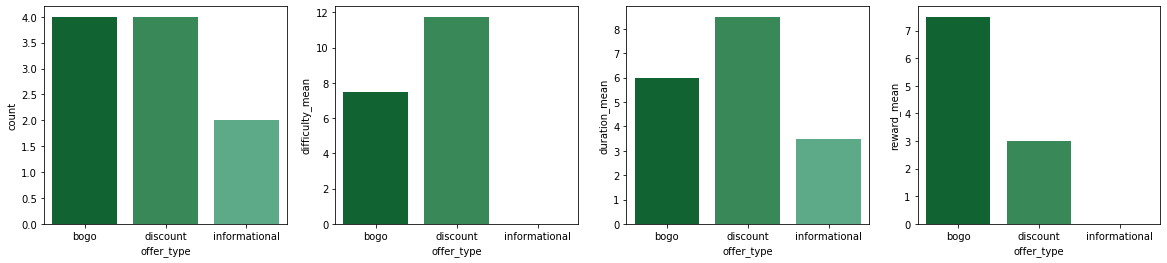

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
cols = port_stats.columns[1:]

for idx, col in enumerate(port_stats.columns[1:]):
    sns.barplot(data=port_stats, x="offer_type", y=col, ax=ax[idx])
    

#### Findings:

* There are 10 different offer types: 4x BOGO, 4x Discount, 2x Informational
* On average for discount offers the difficulty as well as the duration is the highest
* Whereas the reward for BOGO offers is on average the highest

### Profile data

In [44]:
# Drop duplicates
profile.drop_duplicates(inplace=True)

In [45]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [46]:
# If age equals 118 it is considered to be a subsitute for NaN. Therefore, I will convert them to NaN.
profile["age"] = profile["age"].apply(lambda x: np.nan if x == 118 else x)

# Furthermore, I will create an additional column that indicates how long a user's profile alread exists (in days).
today = dt.datetime.now()
profile["became_member_on"] = profile["became_member_on"].apply(lambda x: pd.to_datetime(x, format="%Y%m%d"))
profile["member_duration"] = (today - profile["became_member_on"]).dt.days  

In [47]:
# Check for NaNs
profile.isnull().sum()

age                 2175
became_member_on       0
gender              2175
id                     0
income              2175
member_duration        0
dtype: int64

In [48]:
profile.describe()

,age,income,member_duration
count,14825.000000,14825.000000,17000.000000
mean,54.393524,65404.991568,964.449882
std,17.383705,21598.299410,411.223904
min,18.000000,30000.000000,447.000000
25%,42.000000,49000.000000,655.000000
50%,55.000000,64000.000000,805.000000
75%,66.000000,80000.000000,1238.000000
max,101.000000,120000.000000,2270.000000


Text(0.5, 1.0, 'Distribution of Membership Duration (days)')

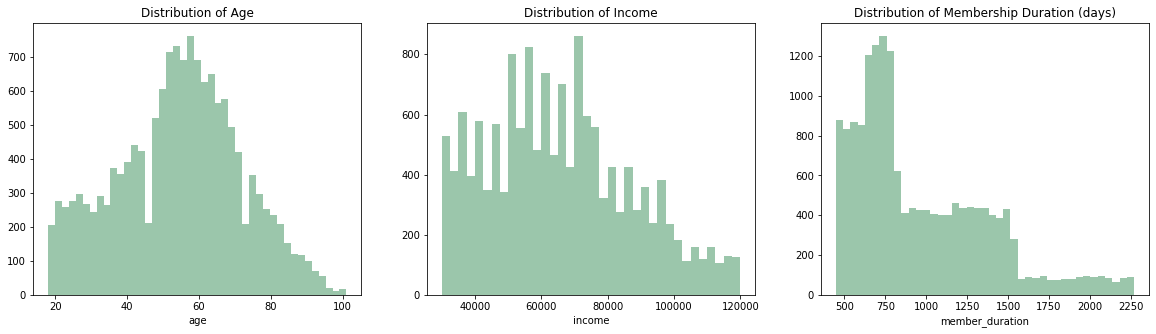

In [49]:
cols = ["age", "income", "member_duration"]

fig, ax = plt.subplots(1, 3, figsize= (20, 5))

for idx, col in enumerate(cols):
    sns.distplot(profile[col].dropna(), hist=True, kde=False, ax=ax[idx])
    
ax[0].set_title("Distribution of Age")
ax[1].set_title("Distribution of Income")
ax[2].set_title("Distribution of Membership Duration (days)")

#### Findings:

* There are 17,000 user profiles available
* 2,175 (~13%) did not provide any demographic data
* The median age is 55 years
* The median income is 64k USD
* The median membership duration is 805 days. According to the histogram Starbucks was able to increase daily sign ups over time.

### Transcript data

In [10]:
# Reload helpers file if needed
# importlib.reload(h)

In [50]:
# Unnest transcript data
offer_ids, amounts, rewards = h.unnest_transcripts(transcript["event"], transcript["value"])

In [51]:
# Assign extracted data to new columns
transcript["offer_id"] = offer_ids
transcript["reward"] = rewards
transcript["amount"] = amounts
del transcript["value"]

In [52]:
# Overview
transcript.head(5)

,event,person,time,offer_id,reward,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [53]:
transcript.drop_duplicates(inplace=True)

In [54]:
# Get descriptive stats for the data
print(transcript.shape)
transcript.describe()

(306137, 6)


,time,reward,amount
count,306137.000000,33182.000000,138953.000000
mean,366.185015,4.902628,12.777356
std,200.348174,2.887201,30.250529
min,0.000000,2.000000,0.050000
25%,186.000000,2.000000,2.780000
50%,408.000000,5.000000,8.890000
75%,528.000000,5.000000,18.070000
max,714.000000,10.000000,1062.280000


In [55]:
trans_data = transcript.groupby(["event", "time"]).size().reset_index()
trans_data.columns = ["event", "time", "count"]
trans_data.head()

,event,time,count
0,offer completed,0,206
1,offer completed,6,276
2,offer completed,12,280
3,offer completed,18,252
4,offer completed,24,265


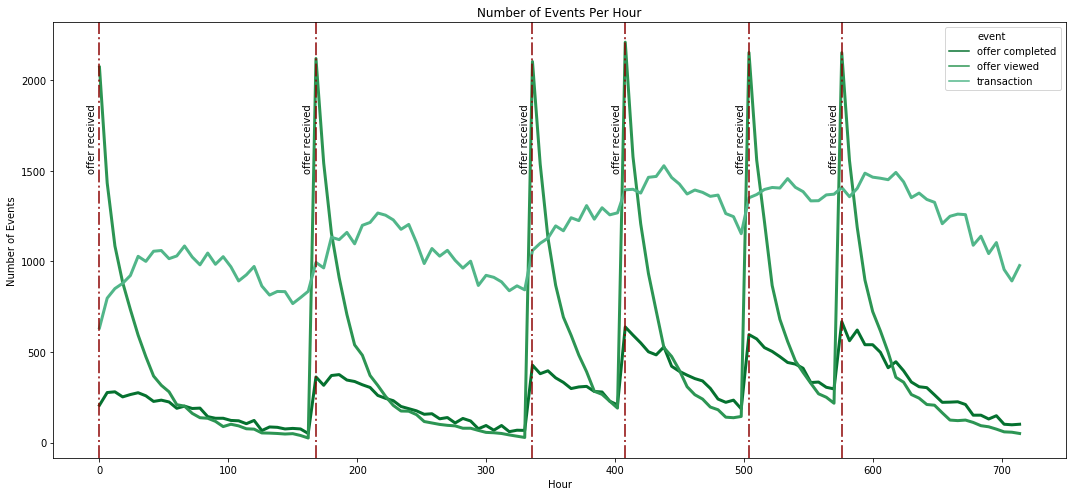

In [56]:
# Set plot size
fig, ax = plt.subplots(1,1, figsize = (15,7))

# Plot time series of offer events (excluding 'offer received')
ax = sns.lineplot(x="time", y="count", hue="event", data=trans_data[(trans_data["event"] == "transaction") |
                                                                    (trans_data["event"] == "offer viewed") |
                                                                    (trans_data["event"] == "offer completed")], linewidth=3.)

# Plot lines for days of offer sendout
for time in trans_data[trans_data["event"] == "offer received"]["time"]:
    plt.axvline(x=time, linestyle="dashdot", linewidth=2., alpha=0.75, color="darkred")
    plt.text(time-10, 1500, "offer received", rotation=90)
    plt.tight_layout()
    
# Label plot
ax.set_ylabel('Number of Events')
ax.set_xlabel('Hour')
ax.set_title('Number of Events Per Hour')
plt.tight_layout()

#### Findings

* Starbucks sent out 6 distinct offers
* Most of the offers are viewed and completed on the same day as they were sent out
* Transaction peaks are slightly delayed
* Higher frequency of offers seems to increase overall transaction level

# 2 - Pre-Processing

#### Approach:

1. Create a data frame showing the rewards per user as well as the according timestamp.
2. Add offer numbers to transcript data in order to see, if a user has seen the same offer more than once.
3. Add transaction IDs to be able to distinguish between distinct transactions.
4. Identify events that were under the influence of an specific offer.
5. Identify transactions that occured under the influence of an offer.
6. Reshape data so the relevant information is available on transaction level.

### 2.1 - Rewards

In [60]:
rel_cols = ["person", "time", "reward"]
reward_df = transcript[transcript["event"]=="offer completed"][rel_cols]
reward_df = reward_df.groupby(["person", "time"]).agg({"reward": "sum"}).reset_index()
reward_df.head()

,person,time,reward
0,0009655768c64bdeb2e877511632db8f,414,5.0
1,0009655768c64bdeb2e877511632db8f,528,2.0
2,0009655768c64bdeb2e877511632db8f,576,2.0
3,0011e0d4e6b944f998e987f904e8c1e5,252,3.0
4,0011e0d4e6b944f998e987f904e8c1e5,576,10.0


### 2.2 - Offer Numbers

In [77]:
# Mark events where a user received an offer
transcript["received_offer"] = transcript["event"].apply(lambda x: 1 if x == "offer received" else np.nan)

# Count how many times a user received a specific offer
transcript["offer_count"] = transcript.groupby(["person", "offer_id", "received_offer"]).cumcount()+1

# Only keep the counts for the "offer received" events
new_offer_count = []
for event, offer_count in zip(transcript.event, transcript.offer_count):
    if event != "offer received":
        new_offer_count.append(np.nan)
    else:
        new_offer_count.append(offer_count)
        
transcript["offer_count"] = new_offer_count

# Assign all events under the influence of an offer to that specific offer
transcript["offer_count"] = transcript.groupby(["person", "offer_id"])["offer_count"].apply(lambda x: x.ffill())
del transcript["received_offer"]
transcript.head()

,event,person,time,offer_id,reward,amount,offer_count
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,1.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,1.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,1.0


### 2.3 - Transaction IDs

In [79]:
transcript["trans_id"] = np.where(transcript['event'] == 'transaction', transcript.index.values, np.nan)

In [87]:
#transcript[transcript["person"]=="0009655768c64bdeb2e877511632db8f"]

### 2.4 - Compare transactions with offer periods

First, isolation of all "transaction" events is required.

In [88]:
trans = transcript[transcript["event"]=="transaction"].drop(["offer_id", "offer_count", "reward"], axis = 1)
trans = trans.merge(reward_df, on=["person", "time"], how="left")
trans["reward"].fillna(0, inplace=True)

In [89]:
trans.head()

,event,person,time,amount,trans_id,reward
0,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,12654.0,0.0
1,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,12657.0,2.0
2,transaction,54890f68699049c2a04d415abc25e717,0,13.23,12659.0,0.0
3,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,12670.0,0.0
4,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,12671.0,2.0


In [90]:
trans[trans["person"]=="0009655768c64bdeb2e877511632db8f"]

,event,person,time,amount,trans_id,reward
37632,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,89291.0,0.0
71464,transaction,0009655768c64bdeb2e877511632db8f,414,8.57,168412.0,5.0
97672,transaction,0009655768c64bdeb2e877511632db8f,528,14.11,228422.0,2.0
103292,transaction,0009655768c64bdeb2e877511632db8f,552,13.56,237784.0,0.0
108756,transaction,0009655768c64bdeb2e877511632db8f,576,10.27,258883.0,2.0
128288,transaction,0009655768c64bdeb2e877511632db8f,660,12.36,293497.0,0.0
134218,transaction,0009655768c64bdeb2e877511632db8f,690,28.16,300930.0,0.0
135267,transaction,0009655768c64bdeb2e877511632db8f,696,18.41,302205.0,0.0


In [99]:
# Pivot table
offer_df = transcript.pivot_table(index=["person", "offer_id", "offer_count"], columns="event", values="time").reset_index()

# Rename columns
offer_df.columns = ["person", "offer_id", "offer_count", "hour_completed", "hour_received", "hour_viewed"]
offer_df.index.name = None

# Add information on offers from portfolio table
offer_df = offer_df.merge(portfolio[["id", "duration"]], 
                          left_on="offer_id", right_on="id", how="left")

# Calculate max. offer duration for distinct offers
offer_df["hour_expired"] = offer_df["hour_received"] + (offer_df["duration"] * 24)

# Defining the end of an offer period (user either completes the offer or the offer expires due to max. duration)
offer_df["hour_ended"] = np.where(offer_df["hour_completed"].isna(), offer_df["hour_expired"], offer_df["hour_completed"])

offer_df.drop(["id", "duration", "hour_expired"], axis=1, inplace=True)

In [100]:
offer_df.head()

,person,offer_id,offer_count,hour_completed,hour_received,hour_viewed,hour_ended
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,576.0,576.0,NaN,576.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.0,NaN,336.0,372.0,432.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1.0,NaN,168.0,192.0,240.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,414.0,408.0,456.0,414.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,528.0,504.0,540.0,528.0


In [159]:
# Join offers and transaction data
tmp = trans.merge(offer_df, on="person", how="left")

# Check if a transaction was actually under the influence of an offer
times, viewed, ended, offer_ids = tmp["time"], tmp["hour_viewed"], tmp["hour_ended"], tmp["offer_id"]
new_offer_ids = []
for time, view, end, offer_id in zip(times, viewed, ended, offer_ids):
    if time >= view and time <= end:
        new_offer_ids.append(offer_id)
    else:
        new_offer_ids.append(np.nan)

tmp["offer_id"] = new_offer_ids
tmp["offer_id"].fillna(0, inplace=True)

# Flag transactions that were influenced by offers
tmp["offer_response"] = tmp["offer_id"].apply(lambda x: np.nan if x==0 else 1)

# Add offer meta data
tmp = tmp.merge(portfolio[["id", "offer_type", "difficulty", "reward"]], how="left", left_on="offer_id", right_on="id")
tmp = tmp.rename(columns = {"reward_x": "received_reward",
                        "reward_y": "expected_reward"})

# Fill NaN values
tmp["difficulty"].fillna(0, inplace=True)
tmp["expected_reward"].fillna(0, inplace=True)
tmp["offer_type"].fillna("none", inplace=True)

# Drop useless columns
tmp.drop(["event", "offer_count", "hour_completed", "hour_received", "hour_viewed", "hour_ended", "id"], axis=1, inplace=True)

#tmp[tmp["person"]=="0009655768c64bdeb2e877511632db8f"]

In [157]:
tmp.head(1)

,person,time,amount,trans_id,received_reward,offer_id,offer_response,offer_type,difficulty,expected_reward
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,12654.0,0.0,0,NaN,none,0.0,0.0


In [160]:
# Use the following columns as index for pivoting
idx = ["person", "time", "trans_id", "amount", "received_reward"]

# Reshape the data frame
tmp_types = tmp.drop("offer_id", axis=1).pivot_table(index=idx, columns=["offer_type"], aggfunc=np.sum).reset_index()

# Rename columns
tmp_types.columns = ['person','time','trans_id','amount','received_reward',
               'difficulty_bogo','difficulty_discount','difficulty_informational', 'difficulty_none',
               'reward_expected_bogo','reward_expected_discount','reward_expected_informational', 'reward_expected_none',
               'bogo_tally','discount_tally','informational_tally', 'none_tally']

# Drop irrelevant columns
tmp_types.drop(['difficulty_none', 'reward_expected_none', 'none_tally'], axis=1, inplace=True)

# Sum difficulties and rewards per offer 
tmp_types["difficulty"] = tmp_types["difficulty_bogo"] + tmp_types["difficulty_discount"] + tmp_types["difficulty_informational"]
tmp_types["reward_expected"] = tmp_types["reward_expected_bogo"] + tmp_types["reward_expected_discount"] + tmp_types["reward_expected_informational"]

# Drop irrelevant columns and rename remaining (add aliases for for offer numbers for better readibility)
drop_cols = ["difficulty_bogo", "difficulty_discount", "difficulty_informational",
            "reward_expected_bogo", "reward_expected_discount", "reward_expected_informational"]

tmp_types.drop(drop_cols, axis=1, inplace=True)

tmp_ids = tmp.drop(["offer_type", "difficulty", "expected_reward"], axis=1).pivot_table(index=idx, columns="offer_id", aggfunc=np.sum).reset_index()
tmp_ids.drop(("offer_response", 0), axis=1, inplace=True)
tmp_ids.columns = ["person", "time", "trans_id", "amount", "received_reward",
                   "tally_offer_1", # 0b1e1539f2cc45b7b9fa7c272da2e1d7
                   "tally_offer_2", # 2298d6c36e964ae4a3e7e9706d1fb8c2
                   "tally_offer_3", # 2906b810c7d4411798c6938adc9daaa5
                   "tally_offer_4", # 3f207df678b143eea3cee63160fa8bed
                   "tally_offer_5", # 4d5c57ea9a6940dd891ad53e9dbe8da0
                   "tally_offer_6", # 5a8bc65990b245e5a138643cd4eb9837
                   "tally_offer_7", # 9b98b8c7a33c4b65b9aebfe6a799e6d9
                   "tally_offer_8", # ae264e3637204a6fb9bb56bc8210ddfd
                   "tally_offer_9", # f19421c1d4aa40978ebb69ca19b0e20d
                   "tally_offer_10" # fafdcd668e3743c1bb461111dcafc2a4
                  ]

# Merge the two resulting data frames and fill nans
tmp_final = tmp_types.merge(tmp_ids, on=["person", "time", "trans_id", "amount", "received_reward"], how="left")
tmp_final.drop("trans_id", axis=1, inplace=True)
tmp_final.fillna(0, inplace=True)

# Turn the offer count columns into binary columns (since users rarely see one offer two times)
binary_cols = ["tally_offer_1", "tally_offer_2", "tally_offer_3", "tally_offer_4", "tally_offer_5", 
               "tally_offer_6", "tally_offer_7", "tally_offer_8", "tally_offer_9", "tally_offer_10",
               "bogo_tally","discount_tally", "informational_tally"]

for col in binary_cols:
    tmp_final[col] = tmp_final[col].apply(lambda x: 1 if x > 1 else x)

In [161]:
tmp_final[tmp_final["person"]=="0009655768c64bdeb2e877511632db8f"]

,person,time,amount,received_reward,bogo_tally,discount_tally,informational_tally,difficulty,reward_expected,tally_offer_1,tally_offer_2,tally_offer_3,tally_offer_4,tally_offer_5,tally_offer_6,tally_offer_7,tally_offer_8,tally_offer_9,tally_offer_10
0,0009655768c64bdeb2e877511632db8f,228,22.16,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0009655768c64bdeb2e877511632db8f,414,8.57,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0009655768c64bdeb2e877511632db8f,528,14.11,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0009655768c64bdeb2e877511632db8f,552,13.56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0009655768c64bdeb2e877511632db8f,576,10.27,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0009655768c64bdeb2e877511632db8f,660,12.36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0009655768c64bdeb2e877511632db8f,690,28.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0009655768c64bdeb2e877511632db8f,696,18.41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [167]:
# Save results to prevent re-running all the pre-processing steps later on
tmp_final.to_csv("data/transactions_final.csv")
transcript.to_csv("data/transcript_final")
reward_df.to_csv("data/rewards_final.csv")
offer_df.to_csv("data/offers_final.csv")
portfolio.to_csv("data/portfolio_final.csv")
profile.to_csv("data/profile_final.csv")

In [166]:
# Load data
transactions = pd.read_csv("data/transactions_final.csv")
transcript = pd.read_csv("data/transcript_final")
reward_df = pd.read_csv("data/rewards_final.csv")
offer_df = pd.read_csv("data/offers_final.csv")
portfolio = pd.read_csv("data/portfolio_final.csv")
profile = pd.read_csv("data/profile_final.csv")

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


# Feature Engineering